In [1]:
import gensim
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn import metrics

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
EMOBANK_CORPUS = "../corpus/emobank.csv"
df = pd.read_csv(EMOBANK_CORPUS)
df.describe()

,V,A,D
count,10062.000000,10062.000000,10062.000000
mean,2.976690,3.041785,3.062763
std,0.348715,0.259541,0.209675
min,1.200000,1.800000,1.780000
25%,2.800000,2.890000,3.000000
50%,3.000000,3.000000,3.090000
75%,3.120000,3.200000,3.200000
max,4.600000,4.400000,4.200000


In [3]:
# VAD has a decent distribution
# Way better than 4000 short stories
df.head()

,id,split,V,A,D,text
0,110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
3,110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...


In [4]:
print("Different splits are: {}".format(set(df["split"].tolist())))

Different splits are: {'test', 'train', 'dev'}


In [5]:
# Dividing into training, validation, and test set
df_train = df[df["split"] == "train"]
df_val = df[df["split"] == "dev"]
df_test = df[df["split"] == "test"]

(df_train.shape, df_val.shape, df_test.shape)

((8062, 6), (1000, 6), (1000, 6))

In [6]:
# Let us first train on Valence
X_train = df_train["text"]
y_train = df_train["A"]

X_val = df_val["text"]
y_val = df_val["A"]

(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((8062,), (8062,), (1000,), (1000,))

In [7]:
# The shape can be a problem
# Let us convert it into a Nx1 dimension

# X_train = X_train.values.reshape(X_train.shape[0], 1)
# y_train = y_train.values.reshape(y_train.shape[0], 1)

# X_val = X_val.values.reshape(X_val.shape[0], 1)
# y_val = y_val.values.reshape(y_val.shape[0], 1)

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

In [8]:
# Much better!
# Preprocessing text

def clean_text(corpus):
    punctuation = """@.,?!:;(){}[]"""
    corpus = [z.strip().lower().replace('\n','') for z in corpus]
    for c in punctuation:
        # inserts whitespace on both sides of a punctuation
        # so that in the next step it gets split
        corpus = [z.replace(c, ' %s '%c) for z in corpus]
    corpus = [z.split() for z in corpus]
    return corpus

X_train = clean_text(X_train)
X_val = clean_text(X_val)

print(X_train[:5])

[['remember', 'what', 'she', 'said', 'in', 'my', 'last', 'letter', '?', '"'], ['.', '.', '"'], ['goodwill', 'helps', 'people', 'get', 'off', 'of', 'public', 'assistance', '.'], ['sherry', 'learned', 'through', 'our', 'future', 'works', 'class', 'that', 'she', 'could', 'rise', 'out', 'of', 'the', 'mire', 'of', 'the', 'welfare', 'system', 'and', 'support', 'her', 'family', '.'], ['coming', 'to', 'goodwill', 'was', 'the', 'first', 'step', 'toward', 'my', 'becoming', 'totally', 'independent', '.']]


In [9]:
# Labelizing h

LabeledSentence = gensim.models.doc2vec.LabeledSentence

def labelize(text, label_type):
    labelized = []
    for i, v in enumerate(text):
        label = '%s_%s'%(label_type, i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

X_train = labelize(X_train, 'TRAIN')
X_val = labelize(X_val, 'DEV')

print(X_train[:2])

[LabeledSentence(words=['remember', 'what', 'she', 'said', 'in', 'my', 'last', 'letter', '?', '"'], tags=['TRAIN_0']), LabeledSentence(words=['.', '.', '"'], tags=['TRAIN_1'])]


/home/parthparikh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':


In [10]:
size = 300

model_dm = gensim.models.Doc2Vec(min_count=1, 
                                 window=10, 
                                 size=size, 
                                 sample=1e-3, 
                                 negative=5, 
                                 workers=3)
model_dbow = gensim.models.Doc2Vec(min_count=1, 
                                   window=10, 
                                   size=size, 
                                   sample=1e-3, 
                                   negative=5, 
                                   dm=0, 
                                   workers=3)

model_dm.build_vocab(X_train + X_val)
model_dbow.build_vocab(X_train + X_val)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [11]:
model_dm.train(X_train, total_examples = len(X_train), epochs=20)
model_dbow.train(X_train, total_examples = len(X_train), epochs=20)

In [12]:
# get vectors
def get_vecs(model, corpus, size):
    vecs = [np.array(model[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

train_vecs_dm = get_vecs(model_dm, X_train, size)
train_vecs_dbow = get_vecs(model_dbow, X_train, size)

train_vecs_dm.shape, train_vecs_dbow.shape

((8062, 300), (8062, 300))

In [13]:
train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))
train_vecs.shape

(8062, 600)

In [14]:
#train over validation set

model_dm.train(X_val, total_examples = len(X_val), epochs=10)
model_dbow.train(X_val, total_examples = len(X_val), epochs=10)

val_vecs_dm = get_vecs(model_dm, X_val, size)
val_vecs_dbow = get_vecs(model_dbow, X_val, size)

val_vecs = np.hstack((val_vecs_dm, val_vecs_dbow))

val_vecs.shape

(1000, 600)

In [15]:
regr = MLPRegressor(hidden_layer_sizes=(400, 100, 10), alpha=1e-4, learning_rate_init=0.001, verbose=True, tol=0.0001, solver='sgd', activation="relu")

scaler = StandardScaler()
scaler.fit(train_vecs)

train_vecs = scaler.transform(train_vecs)
val_vecs = scaler.transform(val_vecs)

pca = PCA(.95)
pca.fit(train_vecs)

train_vecs = pca.transform(train_vecs)
val_vecs = pca.transform(val_vecs)

regr.fit(train_vecs, y_train)

print(regr.score(train_vecs, y_train))
print(regr.score(val_vecs, y_val))

Iteration 1, loss = 1.22518050
Iteration 2, loss = 0.37319826
Iteration 3, loss = 0.27855578
Iteration 4, loss = 0.22327142
Iteration 5, loss = 0.18361786
Iteration 6, loss = 0.15515013
Iteration 7, loss = 0.13314246
Iteration 8, loss = 0.11601008
Iteration 9, loss = 0.10290519
Iteration 10, loss = 0.09164392
Iteration 11, loss = 0.08277791
Iteration 12, loss = 0.07563457
Iteration 13, loss = 0.06970409
Iteration 14, loss = 0.06475951
Iteration 15, loss = 0.06048272
Iteration 16, loss = 0.05696649
Iteration 17, loss = 0.05410765
Iteration 18, loss = 0.05164030
Iteration 19, loss = 0.04946769
Iteration 20, loss = 0.04750373
Iteration 21, loss = 0.04623565
Iteration 22, loss = 0.04466214
Iteration 23, loss = 0.04343734
Iteration 24, loss = 0.04264699
Iteration 25, loss = 0.04146321
Iteration 26, loss = 0.04059277
Iteration 27, loss = 0.03992896
Iteration 28, loss = 0.03937077
Iteration 29, loss = 0.03859615
Iteration 30, loss = 0.03818485
Iteration 31, loss = 0.03767137
Iteration 32, los

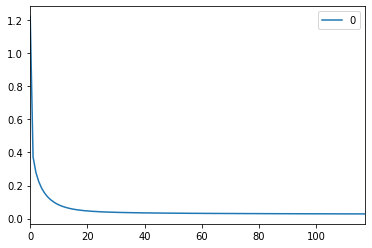

In [16]:
pd.DataFrame(regr.loss_curve_).plot()

In [17]:
n = 13
print(regr.predict([val_vecs[n]]), X_val[n], y_val.iloc[n])

[3.3110755] LabeledSentence(['with', 'unemployment', 'at', 'its', 'lowest', 'point', 'in', 'years', 'in', 'central', 'indiana', ',', 'many', 'people', 'still', 'have', 'a', 'hard', 'time', 'finding', 'meaningful', 'employment', '.'], ['DEV_13']) 3.0


In [18]:
print(regr.loss_)

y_pred = regr.predict(val_vecs)

print(metrics.mean_squared_error(y_val, y_pred))

0.028042856990897102
0.15489400799894382


Text(0, 0.5, 'y pred')

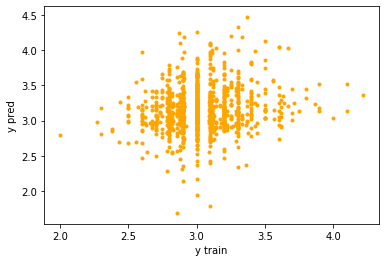

In [19]:
y_pred = regr.predict(val_vecs)
plt.scatter(y_val, y_pred, c="orange", label="MLP-regressor", marker=".")
plt.xlabel("y train")
plt.ylabel("y pred")

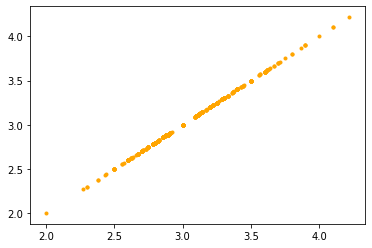

In [20]:
plt.scatter(y_val, y_val, c="orange", label="y_actual_value", marker=".")

In [21]:
# Linear Regression
reg = LinearRegression(normalize=True).fit(train_vecs, y_train)

print(reg.score(train_vecs, y_train))
print(reg.score(val_vecs, y_val))

0.04785611483784058
0.03124678228542699


In [22]:
# SVR
svr_reg = make_pipeline(StandardScaler(), SVR(kernel="rbf", C=1.0, epsilon=0.2))
svr_reg.fit(train_vecs, y_train)

print(svr_reg.score(train_vecs, y_train))
print(svr_reg.score(val_vecs, y_val))

0.3028690145425038
-0.04595709430718742


Text(0, 0.5, 'y pred')

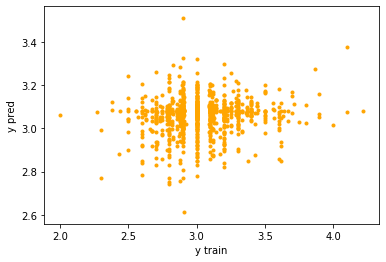

In [23]:
svr_y_pred = svr_reg.predict(val_vecs)
plt.scatter(y_val, svr_y_pred, c="orange", label="MLP-regressor", marker=".")
plt.xlabel("y train")
plt.ylabel("y pred")

In [24]:
print(metrics.mean_squared_error(y_val, svr_y_pred))

0.0658600874106657


0.3028690145425038
-0.04595709430718742


Text(0, 0.5, 'y pred')

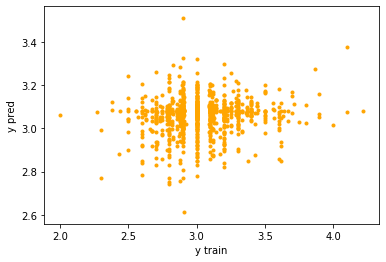

In [25]:
from sklearn.svm import NuSVR

nu_svr_reg = make_pipeline(StandardScaler(), NuSVR(C=1.0, nu=0.1))
nu_svr_reg.fit(train_vecs, y_train)

print(svr_reg.score(train_vecs, y_train))
print(svr_reg.score(val_vecs, y_val))

nu_svr_y_pred = svr_reg.predict(val_vecs)
plt.scatter(y_val, nu_svr_y_pred, c="orange", label="MLP-regressor", marker=".")
plt.xlabel("y train")
plt.ylabel("y pred")

In [26]:
print(metrics.mean_squared_error(y_val, nu_svr_y_pred))

0.0658600874106657
